# Anticipez les besoins en consommation de bâtiments

## Notes

- diminuer la range des observations
- diminuer la complexité du modèle
- essayer de passer les données au log

# Table of contents

* [Imports](#Imports)
* [Feature engineering](#feat_eng)
* [Model: Dummy Regression](#Dummy_Regression)
* [Model: Linear Regression](#Linear_Regression)
* [Model: Ridge](#Ridge)
* [Model: Ridge - grid](#Ridge_grid)
* [Model: Linear Regression - robust](#Linear_Regression_robust)
* [Model: Decision Tree Regression](#Decision_Tree_Regression)
* [Model: Decision Tree Regression - robust](#Decision_Tree_Regression_robust)
* [Model: Decision Tree Regression - grid](#Decision_Tree_Regression_grid)
* [Model: Decision Tree Regression - grid - robust](#Decision_Tree_Regression_grid_robust)
* [Model: Random Forest Regression](#Random_Forest_Regression)
* [Model: Random Forest Regression - robust](#Random_Forest_Regression_robust)
* [Model: Random Forest Regression - grid](#Random_Forest_Regression_grid)
* [Model: Random Forest Regression - grid - robust](#Random_Forest_Regression_grid_robust)
* [Model: Gradient Boosting Regression](#Gradient_Boosting_Regression)
* [Model: Gradient Boosting Regression - robust](#Gradient_Boosting_Regression_robust)
* [Model: Gradient Boosting Regression - grid](#Gradient_Boosting_Regression_grid)
* [Model: Gradient Boosting Regression - grid - robust](#Gradient_Boosting_Regression_grid_robust)
* [Model: Gradient Boosting Regression - grid - log](#Gradient_Boosting_Regression_grid_log)
* [Best result export](#Best_result_export)
* [TotalGHGEmissions prediction](#TotalGHGEmissions_prediction)
* [TotalGHGEmissions prediction with predicted SiteEnergyUseWN(kBtu)](#TotalGHGEmissions_prediction_with_predicted_energy_use)
* [TotalGHGEmissions prediction with predicted SiteEnergyUseWN(kBtu) & ENERGYSTARScore](#TotalGHGEmissions_prediction_with_predicted_energy_use_&_esc)

<a name='Imports'></a>
# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import VarianceThreshold

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import metrics

import json
from datetime import datetime

In [2]:
def resultize(grid):
    """make a fancy df from grid.cv_results"""
    
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if 'split' not in i]
    cols = [i for i in cols if 'std' not in i]
    res = res[cols]
    res = res.sort_values('mean_test_r2', ascending=False)

    return res


def correlationMatrix(df):
    '''Show a correlation matrix for all features.'''
    columns = df.select_dtypes(include=['float64','int64']).columns
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none',cmap='RdYlBu')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    ax.set_xticklabels(columns, rotation = 90)
    ax.set_yticklabels(columns)
    plt.show()


In [3]:
data= pd.read_csv('cleaned_data.csv', sep=',')

In [4]:
data

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Campus,NonResidential,...,Large Office,Medical Office,Mixed Use Property,Retail Store,Small- and Mid-Sized Office,Supermarket / Grocery Store,Warehouse,Worship Facility,CouncilDistrictCode_cat,Building_age
0,47.61220,-122.33799,1.0,12,88434,60.000000,7.456910e+06,249.98,0,1,...,0,0,0,0,0,0,0,0,6,89
1,47.61317,-122.33393,1.0,11,103566,61.000000,8.664479e+06,295.86,0,1,...,0,0,0,0,0,0,0,0,6,20
2,47.61412,-122.33664,1.0,10,61320,56.000000,6.946800e+06,286.43,0,1,...,0,0,0,0,0,0,0,0,6,90
3,47.61375,-122.34047,1.0,18,175580,75.000000,1.465650e+07,505.01,0,1,...,0,0,0,0,0,0,0,0,6,36
4,47.61623,-122.33657,1.0,2,97288,64.895372,1.258171e+07,301.81,0,0,...,0,0,0,0,0,0,0,0,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,47.53161,-122.29944,1.0,2,24990,9.000000,4.731814e+06,134.80,0,1,...,0,0,0,0,1,0,0,0,1,87
1402,47.68109,-122.26180,1.0,1,72000,64.895372,3.198858e+06,67.65,0,1,...,0,0,0,0,0,0,0,0,3,3
1403,47.58831,-122.30650,1.0,3,45000,77.000000,1.397742e+06,9.24,0,1,...,0,0,0,0,0,0,0,0,2,1
1404,47.70541,-122.32232,1.0,1,20616,64.895372,6.369655e+05,4.44,0,0,...,0,0,1,0,0,0,0,0,4,11


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Latitude                     1406 non-null   float64
 1   Longitude                    1406 non-null   float64
 2   NumberofBuildings            1406 non-null   float64
 3   NumberofFloors               1406 non-null   int64  
 4   PropertyGFATotal             1406 non-null   int64  
 5   ENERGYSTARScore              1406 non-null   float64
 6   SiteEnergyUseWN(kBtu)        1406 non-null   float64
 7   TotalGHGEmissions            1406 non-null   float64
 8   Campus                       1406 non-null   int64  
 9   NonResidential               1406 non-null   int64  
 10  Nonresidential COS           1406 non-null   int64  
 11  SPS-District K-12            1406 non-null   int64  
 12  Distribution Center          1406 non-null   int64  
 13  Hotel             

<a name='feat_eng'></a>
# Feature engineering

In [6]:
corrMatrix = data.corr(method='spearman')

In [7]:
corrMatrix.style.applymap(lambda x: 'background-color : lightgreen' if (x >= 0.7) & (x < 0.9)
                          else 'background-color : green' if (x >= 0.9) & (x != 1)
                          else '')

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Campus,NonResidential,Nonresidential COS,SPS-District K-12,Distribution Center,Hotel,K-12 School,Large Office,Medical Office,Mixed Use Property,Retail Store,Small- and Mid-Sized Office,Supermarket / Grocery Store,Warehouse,Worship Facility,CouncilDistrictCode_cat,Building_age
Latitude,1.000000,-0.129200,0.008356,0.181975,-0.006410,0.034865,0.067440,0.061233,-0.038184,0.015310,0.003569,-0.007755,-0.179898,0.053481,0.044171,0.026867,0.050200,0.020402,0.028187,0.032405,0.076412,-0.258610,0.084390,0.610616,-0.089378
Longitude,-0.129200,1.000000,0.048851,-0.121425,-0.068446,-0.027362,-0.035338,-0.001684,0.023641,-0.074190,0.007856,0.083329,0.014574,-0.045879,0.103724,-0.122935,0.103675,-0.004323,0.023601,-0.087726,-0.010996,0.031975,-0.004877,-0.376683,0.004299
NumberofBuildings,0.008356,0.048851,1.000000,-0.032276,0.017983,0.005903,0.027259,0.038588,0.214690,-0.037118,-0.052515,0.006149,0.037376,0.019117,0.039461,-0.012731,-0.016393,0.006600,-0.033240,-0.055732,-0.032271,-0.010333,-0.009450,-0.028691,-0.048111
NumberofFloors,0.181975,-0.121425,-0.032276,1.000000,0.448663,0.153464,0.349235,0.167415,-0.018528,0.156441,-0.110908,-0.105471,-0.193003,0.268069,-0.085290,0.416060,0.065422,0.002860,-0.129426,0.182079,-0.162472,-0.290464,-0.084013,0.460996,-0.040314
PropertyGFATotal,-0.006410,-0.068446,0.017983,0.448663,1.000000,0.172633,0.672539,0.458570,0.019882,-0.052998,-0.059652,0.115984,-0.009763,0.122874,0.044990,0.456912,0.039777,-0.061861,-0.032152,-0.148790,-0.025273,-0.040652,-0.178406,0.153478,-0.265386
ENERGYSTARScore,0.034865,-0.027362,0.005903,0.153464,0.172633,1.000000,-0.115549,-0.089287,-0.009486,-0.146676,-0.054190,0.250091,-0.084933,0.005738,0.229319,0.188143,-0.121308,-0.052199,0.020763,0.052583,-0.107530,-0.134411,0.004645,0.081502,-0.001729
SiteEnergyUseWN(kBtu),0.067440,-0.035338,0.027259,0.349235,0.672539,-0.115549,1.000000,0.827385,0.072979,-0.082068,0.073906,0.014774,-0.109327,0.144575,-0.019729,0.390442,0.068841,-0.028585,-0.002587,-0.149234,0.204892,-0.225850,-0.211328,0.167936,-0.250019
TotalGHGEmissions,0.061233,-0.001684,0.038588,0.167415,0.458570,-0.089287,0.827385,1.000000,0.089348,-0.146028,0.097189,0.073700,-0.078063,0.211697,0.087865,0.210348,0.012414,-0.027859,-0.022261,-0.268954,0.196371,-0.171124,-0.079763,0.094217,-0.116166
Campus,-0.038184,0.023641,0.214690,-0.018528,0.019882,-0.009486,0.072979,0.089348,1.000000,-0.278879,-0.021901,-0.025119,-0.018650,-0.021721,0.070362,-0.032416,-0.015548,0.060964,-0.024305,-0.049340,-0.016939,-0.035556,-0.021357,-0.011454,0.002974
NonResidential,0.015310,-0.074190,-0.037118,0.156441,-0.052998,-0.146676,-0.082068,-0.146028,-0.278879,1.000000,-0.607275,-0.696516,0.054450,0.077886,-0.560612,0.093339,0.040997,0.021973,0.087152,0.154366,0.060740,0.084945,0.076583,0.089109,0.094986


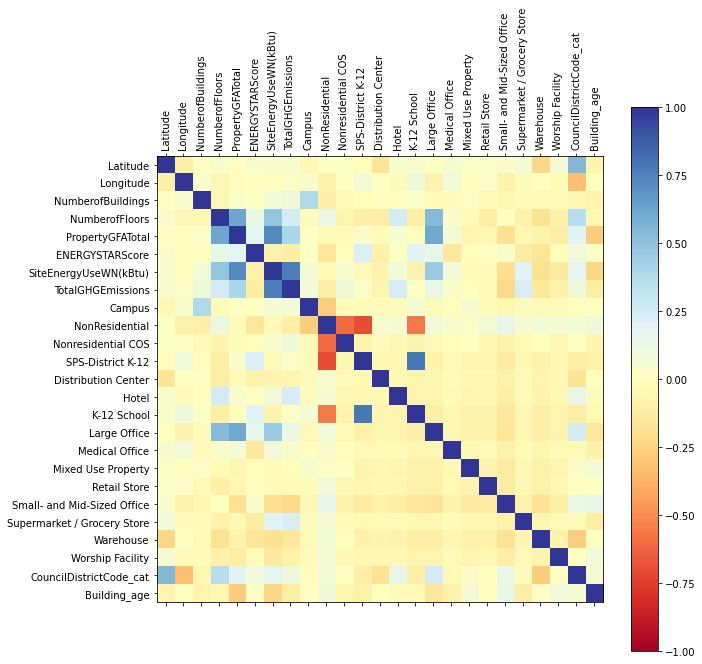

In [8]:
correlationMatrix(data)

In [9]:
features = data.columns.to_list()
features.remove('SiteEnergyUseWN(kBtu)')
features.remove('TotalGHGEmissions')
features.remove('ENERGYSTARScore')

In [10]:
features

['Latitude',
 'Longitude',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'Campus',
 'NonResidential',
 'Nonresidential COS',
 'SPS-District K-12',
 'Distribution Center',
 'Hotel',
 'K-12 School',
 'Large Office',
 'Medical Office',
 'Mixed Use Property',
 'Retail Store',
 'Small- and Mid-Sized Office',
 'Supermarket / Grocery Store',
 'Warehouse',
 'Worship Facility',
 'CouncilDistrictCode_cat',
 'Building_age']

In [11]:
X = data[features]
'''X = data[['NumberofBuildings',
          'NumberofFloors',
          'PropertyGFATotal',
          'Building_age']]'''

y = data['SiteEnergyUseWN(kBtu)']
#y = data['TotalGHGEmissions']

## Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape :', y_test.shape)

X_train shape: (984, 22)
X_test shape:  (422, 22)
y_train shape: (984,)
y_test shape : (422,)


## Data preprocessing

In [13]:
### robust scaler
robust_scaler = preprocessing.RobustScaler().fit(X_train)
X_train_robust = robust_scaler.transform(X_train)
X_test_robust = robust_scaler.transform(X_test)

X_robust = preprocessing.RobustScaler().fit_transform(X)

### standard scaler
#std_scale = preprocessing.StandardScaler().fit(X_train[feat])
#X_train[feat] = std_scale.transform(X_train[feat])
#X_test[feat] = std_scale.transform(X_test[feat])

### normalizer
#normalizer = preprocessing.Normalizer().fit(X_train)
#X_train = normalizer.transform(X_train)
#X_test = normalizer.transform(X_test)

### log
#X_train = np.log(X_train)
#X_test = np.log(X_test)
#X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
#X_train.dropna(subset=feat, how="any", inplace=True)
#X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
#X_test.dropna(subset=feat, how="any", inplace=True)
#y_train = y_train[X_train.index]
#y_test = y_test[X_test.index]

feat = ['PropertyGFATotal'
        #'NumberofFloors',
        #'NumberofBuildings',
        #'Building_age'
       ]
X_log = X.copy()
X_log[feat] = np.log(X_log[feat])
X_log.replace([np.inf, -np.inf], np.nan, inplace=True)
X_log.dropna(how="any", inplace=True)
y_log = y[X_log.index]

In [14]:
print('X shape:', X.shape)
print('y shape:', y.shape)
print()
print('X_robust shape:', X_robust.shape)
print('y shape:', y.shape)
print()
print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape :', y_test.shape)
print()
print('X_train_robust shape:', X_train_robust.shape)
print('X_test_robust shape: ', X_test_robust.shape)
print()
print('X_log shape :', X_log.shape)
print('y_log shape :', y_log.shape)

X shape: (1406, 22)
y shape: (1406,)

X_robust shape: (1406, 22)
y shape: (1406,)

X_train shape: (984, 22)
X_test shape:  (422, 22)
y_train shape: (984,)
y_test shape : (422,)

X_train_robust shape: (984, 22)
X_test_robust shape:  (422, 22)

X_log shape : (1406, 22)
y_log shape : (1406,)


## Feature selection baby

### Remove Low Variance Features

In [15]:
# Perform feature selection using a variance threshold
sel = VarianceThreshold(threshold=(0.02))
sel.fit(X_robust)

print("Feature selection", sel.get_support())
print("Selected features:", list(X.columns[sel.get_support()]))
print("Removed features:", list(X.columns[~sel.get_support()]))

Feature selection [ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
Selected features: ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Distribution Center', 'Hotel', 'K-12 School', 'Large Office', 'Medical Office', 'Mixed Use Property', 'Retail Store', 'Small- and Mid-Sized Office', 'Supermarket / Grocery Store', 'Warehouse', 'Worship Facility', 'CouncilDistrictCode_cat', 'Building_age']
Removed features: ['Campus']


In [16]:
# Transform (remove low variance features)
X_train_robust = sel.transform(X_train_robust)
X_test_robust = sel.transform(X_test_robust)

X = sel.transform(X)
X_robust = sel.transform(X_robust)
X_log = sel.transform(X_log)

C:\Users\axeli\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but VarianceThreshold was fitted without feature names
  warnings.warn(
C:\Users\axeli\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but VarianceThreshold was fitted without feature names
  warnings.warn(


In [17]:
print(X_train_robust.shape)
print(y_train.shape)
print(X_test_robust.shape)
print(y_test.shape)
print()
print(X.shape)
print(y.shape)
print()
print(X_robust.shape)
print(y.shape)
print()
print(X_log.shape)
print(y_log.shape)

(984, 21)
(984,)
(422, 21)
(422,)

(1406, 21)
(1406,)

(1406, 21)
(1406,)

(1406, 21)
(1406,)


### Remove Highly Correlated Features

In [18]:
# Function to list features that are correlated
# Adds the first of the correlated pair only (not both)
def correlatedFeatures(dataset, threshold):
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns

In [19]:
# Get a set of correlated features
cf = correlatedFeatures(pd.DataFrame(X), 0.85)
cf

set()

In [20]:
# Remove the correlated features
X_train_robust = pd.DataFrame(X_train_robust).drop(cf, axis=1)
X_test_robust = pd.DataFrame(X_test_robust).drop(cf, axis=1)

X = pd.DataFrame(X).drop(cf, axis=1)
X_robust = pd.DataFrame(X_robust).drop(cf, axis=1)
X_log = pd.DataFrame(X_log).drop(cf, axis=1)

In [21]:
print(X_train_robust.shape)
print(X_test_robust.shape)
print()
print(X.shape)
print(X_robust.shape)
print(X_log.shape)
y_log = y[X_log.index]

(984, 21)
(422, 21)

(1406, 21)
(1406, 21)
(1406, 21)


<a name='Dummy_Regression'></a>
# Dummy Regression

In [22]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)

y_pred = dummy_regressor.predict(X_test)
#print(y_pred[:10])

print('R2 train score:', dummy_regressor.score(X_train, y_train).round(4))
print('R2 test score :' , dummy_regressor.score(X_test, y_test).round(4))
print()
print('MAE  test (Mean Absolute Error):    ', metrics.mean_absolute_error(y_test, y_pred))
print('MSE  test (Mean Squared Error):     ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred, squared=False))

R2 train score: 0.0
R2 test score : -0.0002

MAE  test (Mean Absolute Error):     3637019.5236724745
MSE  test (Mean Squared Error):      26399221983254.348
RMSE test (Root Mean Squared Error): 5138017.32025636


In [23]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train_robust, y_train)

y_pred = dummy_regressor.predict(X_test_robust)
#print(y_pred[:10])

print('R2 train score:', dummy_regressor.score(X_train_robust, y_train).round(4))
print('R2 test score :' , dummy_regressor.score(X_test_robust, y_test).round(4))
print()
print('MAE  test (Mean Absolute Error):    ', metrics.mean_absolute_error(y_test, y_pred))
print('MSE  test (Mean Squared Error):     ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred, squared=False))

R2 train score: 0.0
R2 test score : -0.0002

MAE  test (Mean Absolute Error):     3637019.5236724745
MSE  test (Mean Squared Error):      26399221983254.348
RMSE test (Root Mean Squared Error): 5138017.32025636


<a name='Linear_Regression'></a>
# Linear Regression - X_train, y_train, X_test, y_test

In [24]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#print(lin_reg.intercept_)
#print(lin_reg.coef_)

y_pred_train = lin_reg.predict(X_train)
#print(y_pred_train[:10])

y_pred = lin_reg.predict(X_test)
#print(y_pred[:10])

print('R2 train score:', lin_reg.score(X_train, y_train).round(4))
print('R2 test score :' , lin_reg.score(X_test, y_test).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test, y_pred))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred, squared=False))

R2 train score: 0.6287
R2 test score : 0.6004

MAE  train (Mean Absolute Error)    : 1909529.4497765524
MSE  train (Mean Squared Error)     : 8633202297015.607
RMSE train (Root Mean Squared Error): 2938231.1510525523

MAE  test (Mean Absolute Error)    : 2020171.8658678043
MSE  test (Mean Squared Error)     : 10547451891175.512
RMSE test (Root Mean Squared Error): 3247684.081183931


<a name='Ridge'></a>
# Ridge - X_train, y_train, X_test, y_test

In [25]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

#print(lin_reg.intercept_)
#print(lin_reg.coef_)

y_pred_train = ridge.predict(X_train)
#print(y_pred_train[:10])

y_pred = ridge.predict(X_test)
#print(y_pred[:10])

print('R2 train score:', ridge.score(X_train, y_train).round(4))
print('R2 test score :' , ridge.score(X_test, y_test).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test, y_pred))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred, squared=False))

R2 train score: 0.6285
R2 test score : 0.601

MAE  train (Mean Absolute Error)    : 1909747.5332421279
MSE  train (Mean Squared Error)     : 8636171649558.431
RMSE train (Root Mean Squared Error): 2938736.4035514365

MAE  test (Mean Absolute Error)    : 2019606.8313340903
MSE  test (Mean Squared Error)     : 10531953873379.305
RMSE test (Root Mean Squared Error): 3245297.193382958


<a name='Ridge_grid'></a>
# Ridge - grid - X, y

In [26]:
estimator = Ridge()

params = {'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X, y)

resultize(grid).head(10)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


,mean_fit_time,mean_score_time,param_alpha,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
7,0.005394,0.004994,8,{'alpha': 8},0.477529,1,0.618656,-3.005817e+06,5,-3.009689e+06
8,0.004994,0.004370,9,{'alpha': 9},0.477526,2,0.618111,-3.006589e+06,7,-3.011825e+06
9,0.005194,0.004395,10,{'alpha': 10},0.477432,3,0.617545,-3.007530e+06,9,-3.014036e+06
6,0.005993,0.004396,7,{'alpha': 7},0.477425,4,0.619178,-3.005248e+06,4,-3.007644e+06
5,0.006393,0.004595,6,{'alpha': 6},0.477195,5,0.619670,-3.004920e+06,2,-3.005711e+06
4,0.005594,0.004594,5,{'alpha': 5},0.476816,6,0.620128,-3.004883e+06,1,-3.003911e+06
3,0.005993,0.004595,4,{'alpha': 4},0.476256,7,0.620545,-3.005200e+06,3,-3.002272e+06
10,0.004996,0.004395,15,{'alpha': 15},0.475986,8,0.614539,-3.013975e+06,11,-3.025759e+06
2,0.005794,0.005557,3,{'alpha': 3},0.475472,9,0.620912,-3.005962e+06,6,-3.000825e+06
1,0.013167,0.005614,2,{'alpha': 2},0.474397,10,0.621221,-3.007306e+06,8,-2.999607e+06


<a name='Linear_Regression_robust'></a>
# Linear Regression - X_train_robust, y_train, X_test_robust, y_test

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_robust, y_train)

#print(lin_reg.intercept_)
#print(lin_reg.coef_)

y_pred_train = lin_reg.predict(X_train_robust)
#print(y_pred_train[:10])

y_pred = lin_reg.predict(X_test_robust)
#print(y_pred[:10])

print('R2 train score:', lin_reg.score(X_train_robust, y_train).round(4))
print('R2 test score :' , lin_reg.score(X_test_robust, y_test).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test, y_pred))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred, squared=False))

R2 train score: 0.6287
R2 test score : 0.6004

MAE  train (Mean Absolute Error)    : 1909529.4497735673
MSE  train (Mean Squared Error)     : 8633202297015.609
RMSE train (Root Mean Squared Error): 2938231.1510525527

MAE  test (Mean Absolute Error)    : 2020171.8658626836
MSE  test (Mean Squared Error)     : 10547451891141.107
RMSE test (Root Mean Squared Error): 3247684.081178634


<a name='Decision_Tree_Regression'></a>
# Decision Tree Regression - X_train, y_train, X_test, y_test

In [28]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

y_pred_train = tree_reg.predict(X_train)
#print(y_pred_train[:10])

y_pred = tree_reg.predict(X_test)
#print(y_pred[:10])

print('R2 train score:', tree_reg.score(X_train, y_train).round(4))
print('R2 test score :' , tree_reg.score(X_test, y_test).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test, y_pred))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred, squared=False))

R2 train score: 1.0
R2 test score : 0.2411

MAE  train (Mean Absolute Error)    : 0.0
MSE  train (Mean Squared Error)     : 0.0
RMSE train (Root Mean Squared Error): 0.0

MAE  test (Mean Absolute Error)    : 2713725.0837499998
MSE  test (Mean Squared Error)     : 20031108381825.99
RMSE test (Root Mean Squared Error): 4475612.62642624


<a name='Decision_Tree_Regression_robust'></a>
# Decision Tree Regression - X_train_robust, y_train, X_test_robust, y_test

In [29]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_robust, y_train)

y_pred_train = tree_reg.predict(X_train_robust)
#print(y_pred_train[:10])

y_pred = tree_reg.predict(X_test_robust)
#print(y_pred[:10])

print('R2 train score:', tree_reg.score(X_train_robust, y_train).round(4))
print('R2 test score :' , tree_reg.score(X_test_robust, y_test).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test, y_pred))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred, squared=False))

R2 train score: 1.0
R2 test score : 0.2102

MAE  train (Mean Absolute Error)    : 0.0
MSE  train (Mean Squared Error)     : 0.0
RMSE train (Root Mean Squared Error): 0.0

MAE  test (Mean Absolute Error)    : 2770078.0189528437
MSE  test (Mean Squared Error)     : 20846042614723.52
RMSE test (Root Mean Squared Error): 4565746.66563132


<a name='Decision_Tree_Regression_grid'></a>
# Decision Tree Regression - GridSearchCV - X, y

In [30]:
estimator = DecisionTreeRegressor()

params = {'max_depth': [1, 2, 3, 5, 6, 7, 8, 9, 10, 15]
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X, y)

resultize(grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,mean_fit_time,mean_score_time,param_max_depth,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
2,0.009988,0.004677,3,{'max_depth': 3},0.367158,1,0.598543,-3.292044e+06,1,-3.090632e+06
3,0.009590,0.004995,5,{'max_depth': 5},0.353229,2,0.684859,-3.358252e+06,2,-2.737331e+06
4,0.008590,0.004395,6,{'max_depth': 6},0.333711,3,0.723568,-3.431148e+06,3,-2.562843e+06
5,0.009590,0.004196,7,{'max_depth': 7},0.294814,4,0.767768,-3.500436e+06,5,-2.350152e+06
1,0.007592,0.004481,2,{'max_depth': 2},0.285454,5,0.525168,-3.482052e+06,4,-3.362246e+06
0,0.005594,0.004596,1,{'max_depth': 1},0.132725,6,0.404519,-3.819386e+06,6,-3.760841e+06
6,0.012587,0.003996,8,{'max_depth': 8},-0.115491,7,0.820663,-4.046957e+06,7,-2.062963e+06
7,0.010389,0.004197,9,{'max_depth': 9},-0.134595,8,0.866264,-4.154556e+06,8,-1.781273e+06
8,0.011388,0.004396,10,{'max_depth': 10},-0.187500,9,0.897896,-4.253668e+06,9,-1.554360e+06
9,0.012386,0.003596,15,{'max_depth': 15},-0.241141,10,0.976753,-4.342649e+06,10,-7.229988e+05


<a name='Decision_Tree_Regression_grid_robust'></a>
# Decision Tree Regression - GridSearchCV - X_robust, y

In [31]:
estimator = DecisionTreeRegressor()

params = {'max_depth': [1, 2, 3, 5, 6, 7, 8, 9, 10, 15]
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X_robust, y)

resultize(grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,mean_fit_time,mean_score_time,param_max_depth,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
2,0.006393,0.003996,3,{'max_depth': 3},0.367158,1,0.598543,-3.292044e+06,1,-3.090632e+06
3,0.008192,0.004195,5,{'max_depth': 5},0.347175,2,0.684859,-3.381996e+06,2,-2.737331e+06
4,0.008990,0.004596,6,{'max_depth': 6},0.345807,3,0.723568,-3.399127e+06,3,-2.562843e+06
5,0.008791,0.004196,7,{'max_depth': 7},0.302892,4,0.767768,-3.469353e+06,4,-2.350152e+06
1,0.005793,0.003996,2,{'max_depth': 2},0.285454,5,0.525168,-3.482052e+06,5,-3.362246e+06
0,0.005594,0.003994,1,{'max_depth': 1},0.132725,6,0.404519,-3.819386e+06,6,-3.760841e+06
7,0.010297,0.004196,9,{'max_depth': 9},-0.080629,7,0.866264,-4.056029e+06,7,-1.781273e+06
6,0.012587,0.004395,8,{'max_depth': 8},-0.105953,8,0.820663,-4.058765e+06,8,-2.062963e+06
8,0.010788,0.004196,10,{'max_depth': 10},-0.111716,9,0.897896,-4.105297e+06,9,-1.554360e+06
9,0.013186,0.003596,15,{'max_depth': 15},-0.277986,10,0.976753,-4.393864e+06,10,-7.229988e+05


<a name='Random_Forest_Regression'></a>
# Random Forest Regression - X_train, y_train, X_test, y_test

In [32]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

y_pred_train = random_forest.predict(X_train)
#print(y_pred_train[:10])

y_pred = random_forest.predict(X_test)
#print(y_pred[:10])

print('R2 train score:', random_forest.score(X_train, y_train).round(4))
print('R2 test score :' , random_forest.score(X_test, y_test).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test, y_pred))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred, squared=False))

R2 train score: 0.9439
R2 test score : 0.5594

MAE  train (Mean Absolute Error)    : 737811.9199874531
MSE  train (Mean Squared Error)     : 1303996902875.8892
RMSE train (Root Mean Squared Error): 1141926.8377947377

MAE  test (Mean Absolute Error)    : 2094037.883164962
MSE  test (Mean Squared Error)     : 11628965554134.236
RMSE test (Root Mean Squared Error): 3410126.911734259


<a name='Random_Forest_Regression_robust'></a>
# Random Forest Regression - X_train_robust, y_train, X_test_robust, y_test

In [33]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train_robust, y_train)

y_pred_train = random_forest.predict(X_train_robust)
#print(y_pred_train[:10])

y_pred = random_forest.predict(X_test_robust)
#print(y_pred[:10])

print('R2 train score:', random_forest.score(X_train_robust, y_train).round(4))
print('R2 test score :' , random_forest.score(X_test_robust, y_test).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test, y_pred))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred, squared=False))

R2 train score: 0.9449
R2 test score : 0.5578

MAE  train (Mean Absolute Error)    : 740184.5238434634
MSE  train (Mean Squared Error)     : 1281010420791.289
RMSE train (Root Mean Squared Error): 1131817.3089290024

MAE  test (Mean Absolute Error)    : 2086675.3309467582
MSE  test (Mean Squared Error)     : 11670746109116.83
RMSE test (Root Mean Squared Error): 3416247.3723541787


<a name='Random_Forest_Regression_grid'></a>
# Random Forest Regression - GridSearchCV - X, y

In [34]:
estimator = RandomForestRegressor()

params = {'n_estimators': [50, 100, 150, 200, 300, 500],
          'max_depth': [4, 5, 6]
          #'min_samples_split': [''],
          #'max_leaf_nodes': ['']
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X, y)

resultize(grid).head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,mean_fit_time,mean_score_time,param_max_depth,param_n_estimators,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
6,0.219290,0.012179,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.444323,1,0.717036,-3.085394e+06,2,-2.594069e+06
10,1.379030,0.049949,5,300,"{'max_depth': 5, 'n_estimators': 300}",0.441287,2,0.719563,-3.089747e+06,4,-2.582545e+06
9,0.979590,0.034578,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.440918,3,0.719781,-3.091956e+06,6,-2.581845e+06
11,2.177127,0.079110,5,500,"{'max_depth': 5, 'n_estimators': 500}",0.440881,4,0.719579,-3.091341e+06,5,-2.582490e+06
0,0.202191,0.012587,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.439627,5,0.673037,-3.080209e+06,1,-2.788106e+06
16,1.440915,0.050663,6,300,"{'max_depth': 6, 'n_estimators': 300}",0.439619,6,0.761343,-3.098041e+06,11,-2.382297e+06
12,0.244796,0.012608,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.439302,7,0.760841,-3.103055e+06,16,-2.385006e+06
14,0.724253,0.028171,6,150,"{'max_depth': 6, 'n_estimators': 150}",0.438596,8,0.761014,-3.096967e+06,10,-2.383882e+06
13,0.479430,0.019580,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.438494,9,0.760754,-3.103095e+06,17,-2.385355e+06
7,0.441944,0.018989,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.438229,10,0.717851,-3.100533e+06,13,-2.590651e+06


<a name='Random_Forest_Regression_grid_robust'></a>
# Random Forest Regression - GridSearchCV - X_robust, y

In [35]:
estimator = RandomForestRegressor()

params = {'n_estimators': [50, 100, 150, 200, 300, 500],
          'max_depth': [4, 5, 6]
          #'min_samples_split': [''],
          #'max_leaf_nodes': ['']
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X_robust, y)

resultize(grid).head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,mean_fit_time,mean_score_time,param_max_depth,param_n_estimators,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
6,0.234014,0.012188,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.447169,1,0.717895,-3.077838e+06,1,-2.590515e+06
8,0.654644,0.026773,5,150,"{'max_depth': 5, 'n_estimators': 150}",0.443918,2,0.719071,-3.080542e+06,2,-2.585044e+06
7,0.442911,0.019586,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.442240,3,0.719263,-3.085924e+06,3,-2.583937e+06
10,1.302257,0.050548,5,300,"{'max_depth': 5, 'n_estimators': 300}",0.441756,4,0.719877,-3.090665e+06,7,-2.581281e+06
11,2.171761,0.081116,5,500,"{'max_depth': 5, 'n_estimators': 500}",0.441348,5,0.719998,-3.089959e+06,6,-2.580650e+06
13,0.481104,0.020779,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.440899,6,0.762622,-3.092492e+06,9,-2.376218e+06
16,1.432172,0.051681,6,300,"{'max_depth': 6, 'n_estimators': 300}",0.440758,7,0.762364,-3.094425e+06,10,-2.377526e+06
9,0.873936,0.034551,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.439090,8,0.719143,-3.095094e+06,11,-2.584715e+06
14,0.737390,0.028642,6,150,"{'max_depth': 6, 'n_estimators': 150}",0.437977,9,0.761624,-3.107871e+06,16,-2.380653e+06
3,0.790784,0.034368,4,200,"{'max_depth': 4, 'n_estimators': 200}",0.437789,10,0.675041,-3.088694e+06,4,-2.779640e+06


<a name='Gradient_Boosting_Regression'></a>
# Gradient Boosting Regression - X_train, y_train, X_test, y_test

In [38]:
#features = data.columns.to_list()
#features.remove('SiteEnergyUseWN(kBtu)')
#features.remove('TotalGHGEmissions')
#features.remove('ENERGYSTARScore')
#X = data[features]
#y = data['SiteEnergyUseWN(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Test with best params from gridSearch later
gbr = GradientBoostingRegressor(learning_rate=0.1,
                                max_depth=1,
                                n_estimators=250)
gbr.fit(X_train, y_train)

y_pred_train = gbr.predict(X_train)
#print(y_pred_train[:10])

predicted_energy_use = gbr.predict(X)
#print(y_pred[:10])

print('R2 train score:', gbr.score(X_train, y_train).round(4))
print('R2 test score :' , gbr.score(X, y).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y, predicted_energy_use))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y, predicted_energy_use))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y, predicted_energy_use, squared=False))

R2 train score: 0.6666
R2 test score : 0.6457

MAE  train (Mean Absolute Error)    : 1727416.9013404564
MSE  train (Mean Squared Error)     : 7591954536764.305
RMSE train (Root Mean Squared Error): 2755350.165907104

MAE  test (Mean Absolute Error)    : 1838935.4083962396
MSE  test (Mean Squared Error)     : 8572518290331.468
RMSE test (Root Mean Squared Error): 2927886.3178633605


<a name='Gradient_Boosting_Regression_robust'></a>
# Gradient Boosting Regression - X_train_robust, y_train, X_test_robust, y_test

In [39]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train_robust, y_train)

y_pred_train = gbr.predict(X_train_robust)
#print(y_pred_train[:10])

y_pred = gbr.predict(X_test_robust)
#print(y_pred[:10])

print('R2 train score:', gbr.score(X_train_robust, y_train).round(4))
print('R2 test score :' , gbr.score(X_test_robust, y_test).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test, y_pred))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred, squared=False))

R2 train score: 0.3906
R2 test score : -0.0792

MAE  train (Mean Absolute Error)    : 2755405.733371939
MSE  train (Mean Squared Error)     : 13874660075953.545
RMSE train (Root Mean Squared Error): 3724870.47774195

MAE  test (Mean Absolute Error)    : 3813062.752037022
MSE  test (Mean Squared Error)     : 29563873291584.07
RMSE test (Root Mean Squared Error): 5437267.079294898


<a name='Gradient_Boosting_Regression_grid'></a>
# Gradient Boosting Regression - GridSearch - X, y

In [40]:
estimator = GradientBoostingRegressor()

params = {'n_estimators': [100, 150, 200, 250, 300, 350, 500, 1000],
          'max_depth': [1, 2, 3],
          'learning_rate': [ 0.1, 0.03, 0.01]
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X, y)

resultize(grid).head(10)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,mean_fit_time,mean_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
2,0.231760,0.005195,0.1,1,200,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.479396,1,0.657305,-2.977443e+06,1,-2.852553e+06
31,1.390994,0.007192,0.03,1,1000,"{'learning_rate': 0.03, 'max_depth': 1, 'n_est...",0.477263,2,0.665164,-2.981403e+06,2,-2.819717e+06
3,0.288302,0.004114,0.1,1,250,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.476966,3,0.662168,-2.984630e+06,4,-2.832272e+06
5,0.420410,0.004995,0.1,1,350,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.475723,4,0.668628,-2.983050e+06,3,-2.805181e+06
1,0.178215,0.004395,0.1,1,150,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.474586,5,0.649485,-2.994388e+06,5,-2.884973e+06
30,0.618762,0.005394,0.03,1,500,"{'learning_rate': 0.03, 'max_depth': 1, 'n_est...",0.472920,6,0.648448,-2.999207e+06,6,-2.889225e+06
4,0.347204,0.004995,0.1,1,300,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.470195,7,0.665739,-3.003335e+06,8,-2.817321e+06
36,0.564019,0.005994,0.03,2,300,"{'learning_rate': 0.03, 'max_depth': 2, 'n_est...",0.468713,8,0.690922,-3.007958e+06,9,-2.710004e+06
6,0.585622,0.005394,0.1,1,500,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.468696,9,0.675325,-2.999821e+06,7,-2.776879e+06
35,0.461924,0.004995,0.03,2,250,"{'learning_rate': 0.03, 'max_depth': 2, 'n_est...",0.468409,10,0.682446,-3.008112e+06,11,-2.746691e+06


<a name='Gradient_Boosting_Regression_grid_robust'></a>
# Gradient Boosting Regression - GridSearch - X_robust, y

In [41]:
estimator = GradientBoostingRegressor()

params = {'n_estimators': [100, 150, 200, 250, 300, 350, 500, 1000],
          'max_depth': [1, 2, 3],
          'learning_rate': [ 0.1, 0.03, 0.01]
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X_robust, y)

resultize(grid).head(10)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,mean_fit_time,mean_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
3,0.390143,0.005595,0.1,1,250,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.478530,1,0.662168,-2.979513e+06,1,-2.832272e+06
31,1.230881,0.007593,0.03,1,1000,"{'learning_rate': 0.03, 'max_depth': 1, 'n_est...",0.477699,2,0.665164,-2.979970e+06,2,-2.819717e+06
5,0.476509,0.005195,0.1,1,350,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.475450,3,0.668628,-2.983956e+06,3,-2.805181e+06
1,0.207187,0.006993,0.1,1,150,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.475195,4,0.649485,-2.992375e+06,6,-2.884973e+06
2,0.267523,0.006393,0.1,1,200,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.474860,5,0.657305,-2.992287e+06,5,-2.852553e+06
4,0.452733,0.007392,0.1,1,300,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.474252,6,0.665739,-2.990360e+06,4,-2.817321e+06
30,0.641138,0.006194,0.03,1,500,"{'learning_rate': 0.03, 'max_depth': 1, 'n_est...",0.472292,7,0.648448,-3.001271e+06,7,-2.889225e+06
42,0.613767,0.005794,0.03,3,200,"{'learning_rate': 0.03, 'max_depth': 3, 'n_est...",0.468623,8,0.732186,-3.014936e+06,13,-2.524312e+06
35,0.507686,0.005984,0.03,2,250,"{'learning_rate': 0.03, 'max_depth': 2, 'n_est...",0.468491,9,0.682446,-3.007854e+06,9,-2.746691e+06
36,0.602332,0.005647,0.03,2,300,"{'learning_rate': 0.03, 'max_depth': 2, 'n_est...",0.468449,10,0.690922,-3.008349e+06,10,-2.710004e+06


<a name='Gradient_Boosting_Regression_grid_log'></a>
# Gradient Boosting Regression - GridSearch - X_log, y_log

In [42]:
estimator = GradientBoostingRegressor()

params = {'n_estimators': [100, 150, 200, 250, 300, 350],
          'max_depth': [1, 2, 3],
          'learning_rate': [1, 0.3, 0.1, 0.03, 0.01]
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X_log, y_log)

resultize(grid).head(10)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


,mean_fit_time,mean_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
38,0.246546,0.005994,0.1,1,200,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.479704,1,0.657305,-2.976422e+06,1,-2.852553e+06
39,0.333656,0.006194,0.1,1,250,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.476836,2,0.662168,-2.985053e+06,2,-2.832272e+06
40,0.426360,0.006402,0.1,1,300,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.475464,3,0.665739,-2.986407e+06,3,-2.817321e+06
18,0.123027,0.004595,0.3,1,100,"{'learning_rate': 0.3, 'max_depth': 1, 'n_esti...",0.474048,4,0.666447,-2.991641e+06,4,-2.814397e+06
37,0.184210,0.004595,0.1,1,150,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.472800,5,0.649485,-3.000234e+06,6,-2.884973e+06
41,0.481303,0.005594,0.1,1,350,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.471010,6,0.668628,-2.998380e+06,5,-2.805181e+06
63,0.484900,0.005395,0.03,2,250,"{'learning_rate': 0.03, 'max_depth': 2, 'n_est...",0.469288,7,0.682446,-3.005296e+06,7,-2.746691e+06
64,0.584321,0.005394,0.03,2,300,"{'learning_rate': 0.03, 'max_depth': 2, 'n_est...",0.468339,8,0.690922,-3.008255e+06,8,-2.710004e+06
65,0.688414,0.005394,0.03,2,350,"{'learning_rate': 0.03, 'max_depth': 2, 'n_est...",0.467797,9,0.697850,-3.010033e+06,9,-2.679619e+06
42,0.240377,0.005968,0.1,2,100,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.467289,10,0.697596,-3.012838e+06,10,-2.680762e+06


<a name='Best_result_export'></a>
# Export for data history

In [43]:
params = str(grid.best_params_)
score = round(grid.best_score_, 4)
duration = round(grid.refit_time_, 4)
variables = X.columns.to_list()

time = datetime.now()
dt_string = time.strftime("%d-%m-%Y %H-%M-%S")

print(params)
print(score)
print(duration)
print(dt_string)

dictionary = {'params': params,
              'score': score,
              'duration:': duration,
              'date:': dt_string,
              'variables': variables}

f = open(str(score).replace('.', ',') + '   ' + dt_string + '.txt', 'w')
f.write(str(dictionary))
f.close()

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200}
0.4797
0.1718
17-11-2022 15-32-31


<a name='TotalGHGEmissions_prediction'></a>
# TotalGHGEmissions prediction

In [44]:
features = data.columns.to_list()
#features.remove('SiteEnergyUseWN(kBtu)')
features.remove('TotalGHGEmissions')
features.remove('ENERGYSTARScore')
X = data[features]
y = data['TotalGHGEmissions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Test with best params from gridSearch later
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                max_depth=4,
                                n_estimators=800)
gbr.fit(X_train, y_train)

y_pred_train = gbr.predict(X_train)
#print(y_pred_train[:10])

y_pred = gbr.predict(X)
#print(y_pred[:10])

print('R2 train score:', gbr.score(X_train, y_train).round(4))
print('R2 test score :' , gbr.score(X, y).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y, y_pred))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y, y_pred))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y, y_pred, squared=False))

R2 train score: 0.9271
R2 test score : 0.8763

MAE  train (Mean Absolute Error)    : 19.798643949475682
MSE  train (Mean Squared Error)     : 785.3903526752326
RMSE train (Root Mean Squared Error): 28.024816728664483

MAE  test (Mean Absolute Error)    : 23.368622342524123
MSE  test (Mean Squared Error)     : 1295.1769677595714
RMSE test (Root Mean Squared Error): 35.98856718125315


In [45]:
estimator = GradientBoostingRegressor()

params = {'n_estimators': [700, 800, 900, 1000],
          'max_depth': [2, 3, 4, 5],
          'learning_rate': [0.03, 0.01, 0.003]
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X, y)

resultize(grid).head(10)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,mean_fit_time,mean_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
25,3.418334,0.011588,0.01,4,800,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.725922,1,0.922397,-50.336739,2,-28.367449
27,4.308323,0.011588,0.01,4,1000,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.725887,2,0.933386,-50.327008,1,-26.285816
26,3.742419,0.012210,0.01,4,900,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.725723,3,0.928191,-50.343403,3,-27.288612
24,2.907090,0.009984,0.01,4,700,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.725102,4,0.915771,-50.425697,4,-29.554130
28,3.734901,0.013377,0.01,5,700,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.722490,5,0.951841,-50.758842,5,-22.342139
29,4.276411,0.012003,0.01,5,800,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.721541,6,0.956681,-50.833632,6,-21.190629
30,4.440038,0.012587,0.01,5,900,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.720522,7,0.960996,-50.918683,7,-20.106944
31,4.956137,0.015984,0.01,5,1000,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.719800,8,0.964554,-50.984484,8,-19.168194
12,3.762123,0.009990,0.03,5,700,"{'learning_rate': 0.03, 'max_depth': 5, 'n_est...",0.719749,9,0.987624,-51.013299,9,-11.311582
13,4.606091,0.011969,0.03,5,800,"{'learning_rate': 0.03, 'max_depth': 5, 'n_est...",0.718707,10,0.990497,-51.108697,11,-9.913609


<a name='TotalGHGEmissions_prediction_with_predicted_energy_use'></a>
# TotalGHGEmissions prediction with predicted SiteEnergyUseWN(kBtu)

In [46]:
features = data.columns.to_list()
features.remove('SiteEnergyUseWN(kBtu)')
features.remove('TotalGHGEmissions')
features.remove('ENERGYSTARScore')
X = data[features]
y = data['SiteEnergyUseWN(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Test with best params from gridSearch later
gbr = GradientBoostingRegressor(learning_rate=0.1,
                                max_depth=1,
                                n_estimators=250)
gbr.fit(X_train, y_train)

y_pred_train = gbr.predict(X_train)
#print(y_pred_train[:10])

predicted_energy_use = gbr.predict(X_test)
#print(y_pred[:10])

print('R2 train score:', gbr.score(X_train, y_train).round(4))
print('R2 test score :' , gbr.score(X_test, y_test).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train, y_pred_train, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test, predicted_energy_use))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test, predicted_energy_use))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test, predicted_energy_use, squared=False))

R2 train score: 0.6696
R2 test score : 0.6062

MAE  train (Mean Absolute Error)    : 1719989.1580895074
MSE  train (Mean Squared Error)     : 7680780758652.516
RMSE train (Root Mean Squared Error): 2771422.154535919

MAE  test (Mean Absolute Error)    : 2076073.99063442
MSE  test (Mean Squared Error)     : 10378813941183.76
RMSE test (Root Mean Squared Error): 3221616.665772599


In [47]:
print(X_test.shape)
print(y_test.shape)
print(predicted_energy_use.shape)
X_test['predicted_energy_use'] = predicted_energy_use
print(X_test.shape)
y_test = data['TotalGHGEmissions'][y_test.index]

(422, 22)
(422,)
(422,)
(422, 23)


In [48]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_test, y_test, test_size=0.3)

# Test with best params from gridSearch later
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                max_depth=1,
                                n_estimators=900)
gbr.fit(X_train2, y_train2)

y_pred_train2 = gbr.predict(X_train2)
#print(y_pred_train[:10])

y_pred2 = gbr.predict(X_test2)
#print(y_pred[:10])

print('R2 train score:', gbr.score(X_train2, y_train2).round(4))
print('R2 test score :' , gbr.score(X_test2, y_test2).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train2, y_pred_train2))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train2, y_pred_train2))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train2, y_pred_train2, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test2, y_pred2))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test2, y_pred2))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test2, y_pred2, squared=False))

R2 train score: 0.442
R2 test score : 0.1373

MAE  train (Mean Absolute Error)    : 54.942323329517436
MSE  train (Mean Squared Error)     : 6126.161150172514
RMSE train (Root Mean Squared Error): 78.26979717727978

MAE  test (Mean Absolute Error)    : 75.27179318883783
MSE  test (Mean Squared Error)     : 9792.774805588739
RMSE test (Root Mean Squared Error): 98.95844989483585


In [49]:
estimator = GradientBoostingRegressor()

params = {'n_estimators': [700, 800, 900, 1000],
          'max_depth': [1, 2, 3],
          'learning_rate': [0.1, 0.03, 0.01]
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X_test, y_test)

resultize(grid).head(10)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,mean_fit_time,mean_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
27,0.815821,0.006211,0.01,1,1000,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.254847,1,0.395740,-89.413589,1,-81.846566
26,0.750762,0.005994,0.01,1,900,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.254167,2,0.388626,-89.475330,2,-82.328703
25,0.706440,0.005794,0.01,1,800,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.252924,3,0.380795,-89.572424,3,-82.856140
24,0.635344,0.007894,0.01,1,700,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.251041,4,0.372088,-89.709790,4,-83.438629
12,0.600886,0.011395,0.03,1,700,"{'learning_rate': 0.03, 'max_depth': 1, 'n_est...",0.238971,5,0.448534,-90.090714,5,-78.180910
13,0.767311,0.009590,0.03,1,800,"{'learning_rate': 0.03, 'max_depth': 1, 'n_est...",0.233806,6,0.458644,-90.327884,6,-77.459698
14,0.757654,0.006898,0.03,1,900,"{'learning_rate': 0.03, 'max_depth': 1, 'n_est...",0.231510,7,0.467906,-90.404310,7,-76.792915
15,0.824983,0.005298,0.03,1,1000,"{'learning_rate': 0.03, 'max_depth': 1, 'n_est...",0.227109,8,0.476489,-90.606504,8,-76.169725
28,0.775675,0.005994,0.01,2,700,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.212320,9,0.578915,-91.425009,9,-68.323695
29,0.830920,0.005794,0.01,2,800,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.201447,10,0.606839,-91.919064,10,-66.023298


<a name='TotalGHGEmissions_prediction_with_predicted_energy_use_&_esc'></a>
# TotalGHGEmissions prediction with predicted SiteEnergyUseWN(kBtu) & ENERGYSTARScore

In [50]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 1340 to 397
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Latitude                     422 non-null    float64
 1   Longitude                    422 non-null    float64
 2   NumberofBuildings            422 non-null    float64
 3   NumberofFloors               422 non-null    int64  
 4   PropertyGFATotal             422 non-null    int64  
 5   Campus                       422 non-null    int64  
 6   NonResidential               422 non-null    int64  
 7   Nonresidential COS           422 non-null    int64  
 8   SPS-District K-12            422 non-null    int64  
 9   Distribution Center          422 non-null    int64  
 10  Hotel                        422 non-null    int64  
 11  K-12 School                  422 non-null    int64  
 12  Large Office                 422 non-null    int64  
 13  Medical Office   

In [51]:
print(X_test.shape)
'''X_test = X_test[['Latitude',
                 'Longitude',
                 'NumberofBuildings',
                 'NumberofFloors',
                 'PropertyGFATotal',
                 'Building_age',
                 'predicted_energy_use']]'''
X_test['ENERGYSTARScore'] = data['ENERGYSTARScore'][X_test.index]
print(X_test.shape)
print(y_test.shape)

(422, 23)
(422, 24)
(422,)


In [52]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_test, y_test, test_size=0.3)

gbr = GradientBoostingRegressor(learning_rate=0.003,
                                max_depth=3,
                                n_estimators=1200)
gbr.fit(X_train2, y_train2)

y_pred_train2 = gbr.predict(X_train2)
#print(y_pred_train[:10])

y_pred2 = gbr.predict(X_test2)
#print(y_pred[:10])

print('R2 train score:', gbr.score(X_train2, y_train2).round(4))
print('R2 test score :' , gbr.score(X_test2, y_test2).round(4))
print()
print('MAE  train (Mean Absolute Error)    :', metrics.mean_absolute_error(y_train2, y_pred_train2))
print('MSE  train (Mean Squared Error)     :', metrics.mean_squared_error(y_train2, y_pred_train2))
print('RMSE train (Root Mean Squared Error):', metrics.mean_squared_error(y_train2, y_pred_train2, squared=False))
print()
print('MAE  test (Mean Absolute Error)    :', metrics.mean_absolute_error(y_test2, y_pred2))
print('MSE  test (Mean Squared Error)     :', metrics.mean_squared_error(y_test2, y_pred2))
print('RMSE test (Root Mean Squared Error):', metrics.mean_squared_error(y_test2, y_pred2, squared=False))

R2 train score: 0.679
R2 test score : 0.3455

MAE  train (Mean Absolute Error)    : 42.612120474778145
MSE  train (Mean Squared Error)     : 3437.770592980781
RMSE train (Root Mean Squared Error): 58.632504577075515

MAE  test (Mean Absolute Error)    : 60.56696590250165
MSE  test (Mean Squared Error)     : 7825.687705901503
RMSE test (Root Mean Squared Error): 88.46291712294764


In [53]:
estimator = GradientBoostingRegressor()

params = {'n_estimators': [50, 100, 950, 1000, 1100, 1200],
          'max_depth': [1, 2, 3, 4],
          'learning_rate': [0.01, 0.003, 0.001]
         }

grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring=['r2', 'neg_root_mean_squared_error'],
                    n_jobs=-1,
                    refit='r2',
                    cv=5,
                    return_train_score=True,
                    verbose=3)

grid.fit(X_test, y_test)

resultize(grid).head(10)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,mean_fit_time,mean_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,mean_test_r2,rank_test_r2,mean_train_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
5,0.907016,0.007879,0.01,1,1200,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.282809,1,0.440502,-87.707807,1,-78.754897
4,0.828215,0.005794,0.01,1,1100,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.282764,2,0.434301,-87.722556,2,-79.191309
3,0.748429,0.005596,0.01,1,1000,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.282209,3,0.427525,-87.770706,3,-79.665645
2,0.688921,0.005701,0.01,1,950,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.281757,4,0.423886,-87.803165,4,-79.919306
35,1.253145,0.007796,0.003,2,1200,"{'learning_rate': 0.003, 'max_depth': 2, 'n_es...",0.273449,5,0.509463,-88.181695,5,-73.738404
34,1.168267,0.006803,0.003,2,1100,"{'learning_rate': 0.003, 'max_depth': 2, 'n_es...",0.271620,6,0.497399,-88.326039,6,-74.638924
33,1.067149,0.006193,0.003,2,1000,"{'learning_rate': 0.003, 'max_depth': 2, 'n_es...",0.270642,7,0.483831,-88.411847,7,-75.638405
32,1.016995,0.006393,0.003,2,950,"{'learning_rate': 0.003, 'max_depth': 2, 'n_es...",0.270106,8,0.476555,-88.457336,8,-76.169599
39,1.323363,0.006403,0.003,3,1000,"{'learning_rate': 0.003, 'max_depth': 3, 'n_es...",0.265461,9,0.627460,-88.745849,9,-64.268313
40,1.450034,0.007992,0.003,3,1100,"{'learning_rate': 0.003, 'max_depth': 3, 'n_es...",0.265115,10,0.644519,-88.778130,11,-62.774726


In [54]:
data['TotalGHGEmissions']

0       249.98
1       295.86
2       286.43
3       505.01
4       301.81
         ...  
1401    134.80
1402     67.65
1403      9.24
1404      4.44
1405    259.22
Name: TotalGHGEmissions, Length: 1406, dtype: float64

In [55]:
data['TotalGHGEmissions'].mean()

89.88150071123759